In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import dlc_practical_prologue as prologue
from torch import optim
import matplotlib.pyplot as plt

In [2]:
print("torch.cuda.is_available()   =", torch.cuda.is_available())
print("torch.cuda.device_count()   =", torch.cuda.device_count())
print("torch.cuda.device('cuda')   =", torch.cuda.device('cuda'))
print("torch.cuda.current_device() =", torch.cuda.current_device())

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')

torch.cuda.is_available()   = True
torch.cuda.device_count()   = 1
torch.cuda.device('cuda')   = <torch.cuda.device object at 0x0000019C2DFD1908>
torch.cuda.current_device() = 0


In [3]:
#generate train and test data
#target classes: a>b->0   a<=b->1

[train_input,train_target,train_classes,
 test_input,test_target,test_classes]=prologue.generate_pair_sets(1000)

train_input, train_target = Variable(train_input), Variable(train_target)
test_input, test_target = Variable(test_input), Variable(test_target)

train_input, train_target,train_classes = train_input.to(device), train_target.to(device),train_classes.to(device)
test_input, test_target,test_classes = test_input.to(device), test_target.to(device),test_classes.to(device)

# Simple

In [14]:
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        nb_hidden=130
        self.conv1 = nn.Conv2d(2, 32, kernel_size=7)
        self.fc1 = nn.Linear(16* 32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)

        x=x.view(-1, 16*32)

        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        nb_hidden=90
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.fc1 = nn.Linear(16* 32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=1)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)

        x=x.view(-1, 16*32)

        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)

        return x 
    
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        nb_hidden=100
        self.conv1 = nn.Conv2d(2, 64, kernel_size=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=2)
        self.fc1 = nn.Linear(4* 32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=1)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=1)

        x=x.view(-1, 4*32)

        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)

        return x      

# With weight sharing


In [5]:
class ConvNet1_ws(nn.Module):
    def __init__(self):
        super(ConvNet1_ws, self).__init__()
        nb_hidden=70
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7)
        self.fc1 = nn.Linear(32* 32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x1=torch.zeros(mini_batch_size,1,14,14)   
        x2=torch.zeros(mini_batch_size,1,14,14) 
        
        x1[:,0,:,:]=x[:,0,:,:]
        x2[:,0,:,:]=x[:,1,:,:]
        x1 = F.max_pool2d(F.relu(self.conv1(x1)), kernel_size=2)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv1.weight)), kernel_size=2)
        x1=x1.view(-1, 16*32)
        x2=x2.view(-1, 16*32)
        x=torch.cat((x1,x2),1)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)

        return x
 #2 conv layer   
class ConvNet2_ws(nn.Module):
    def __init__(self):
        super(ConvNet2_ws, self).__init__()
        nb_hidden=50
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.fc1 = nn.Linear(32* 32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x1=torch.zeros(mini_batch_size,1,14,14)   
        x2=torch.zeros(mini_batch_size,1,14,14) 
        
        x1[:,0,:,:]=x[:,0,:,:]
        x2[:,0,:,:]=x[:,1,:,:]
        x1 = F.max_pool2d(F.relu(self.conv1(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv1.weight)), kernel_size=1)
        
        x1 = F.max_pool2d(F.relu(self.conv2(x1)), kernel_size=2)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv2.weight)), kernel_size=2)
        
        x1=x1.view(-1, 16*32)
        x2=x2.view(-1, 16*32)
        x=torch.cat((x1,x2),1)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x  
    

 #3 conv layer   
class ConvNet3_ws(nn.Module):
    def __init__(self):
        super(ConvNet3_ws, self).__init__()
        nb_hidden=150
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=2)
        
        self.fc1 = nn.Linear(8* 32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x1=torch.zeros(mini_batch_size,1,14,14)   
        x2=torch.zeros(mini_batch_size,1,14,14) 
        
        x1[:,0,:,:]=x[:,0,:,:]
        x2[:,0,:,:]=x[:,1,:,:]
        x1 = F.max_pool2d(F.relu(self.conv1(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv1.weight)), kernel_size=1)
        
        x1 = F.max_pool2d(F.relu(self.conv2(x1)), kernel_size=2)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv2.weight)), kernel_size=2)
        
        x1 = F.max_pool2d(F.relu(self.conv3(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv3.weight)), kernel_size=1)
        x1=x1.view(-1, 4*32)
        x2=x2.view(-1, 4*32)
        x=torch.cat((x1,x2),1)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    
#6 conv layer   
class ConvNet6_ws(nn.Module):
    def __init__(self):
        super(ConvNet6_ws, self).__init__()
        nb_hidden=130
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=2)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=2)
        self.fc1 = nn.Linear(8* 32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x1=torch.zeros(mini_batch_size,1,14,14)   
        x2=torch.zeros(mini_batch_size,1,14,14) 
        
        x1[:,0,:,:]=x[:,0,:,:]
        x2[:,0,:,:]=x[:,1,:,:]
        x1 = F.relu(self.conv1(x1))
        x2 = F.relu(F.conv2d(x2,self.conv1.weight))
        
        x1 = F.max_pool2d(F.relu(self.conv2(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv2.weight)), kernel_size=1)
        
        x1 = F.max_pool2d(F.relu(self.conv3(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv3.weight)), kernel_size=1)
        
        x1 = F.max_pool2d(F.relu(self.conv4(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv4.weight)), kernel_size=1)
        
        x1 = F.max_pool2d(F.relu(self.conv5(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv5.weight)), kernel_size=1)
        
        x1 = F.max_pool2d(F.relu(self.conv6(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv6.weight)), kernel_size=1)
        
        
        x1=x1.view(-1, 4*32)
        x2=x2.view(-1, 4*32)
        x=torch.cat((x1,x2),1)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

# With auxiliary loss

In [6]:
class ConvNet2_al(nn.Module):
    def __init__(self):
        super(ConvNet2_al, self).__init__()
        nb_hidden=80
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=9)
        
        self.lin_aux1 = nn.Linear(4* 32, 100)
        self.lin_aux2 = nn.Linear(100, 10)
                
        self.fc1 = nn.Linear(8* 32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x1=torch.zeros(mini_batch_size,1,14,14)   
        x2=torch.zeros(mini_batch_size,1,14,14) 
        
        x1[:,0,:,:]=x[:,0,:,:]
        x2[:,0,:,:]=x[:,1,:,:]
        x1 = F.max_pool2d(F.relu(self.conv1(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv1.weight)), kernel_size=1)
        
        x1 = F.max_pool2d(F.relu(self.conv2(x1)), kernel_size=2)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv2.weight)), kernel_size=2)
        
        x1=x1.view(-1, 4*32)
        x2=x2.view(-1, 4*32)
        
        x1_aux=torch.sigmoid(self.lin_aux1(x1))
        x1_aux=self.lin_aux2(x1_aux)
        
        x2_aux=torch.sigmoid(self.lin_aux1(x2))
        x2_aux=self.lin_aux2(x2_aux)
        
        x = torch.cat((x1,x2),1)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x,x1_aux,x2_aux

class ConvNet3_al(nn.Module):
    def __init__(self):
        super(ConvNet3_al, self).__init__()
        nb_hidden=120
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=9)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        
        self.lin_aux1 = nn.Linear(4* 32, 100)
        self.lin_aux2 = nn.Linear(100, 10)
                
        self.fc1 = nn.Linear(8* 32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x1=torch.zeros(mini_batch_size,1,14,14)   
        x2=torch.zeros(mini_batch_size,1,14,14) 
        
        x1[:,0,:,:]=x[:,0,:,:]
        x2[:,0,:,:]=x[:,1,:,:]
        x1 = F.max_pool2d(F.relu(self.conv1(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv1.weight)), kernel_size=1)
        
        x1 = F.max_pool2d(F.relu(self.conv2(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv2.weight)), kernel_size=1)
        
        x1 = F.max_pool2d(F.relu(self.conv3(x1)), kernel_size=1)
        x2 = F.max_pool2d(F.relu(F.conv2d(x2,self.conv3.weight)), kernel_size=1)
        x1=x1.view(-1, 4*32)
        x2=x2.view(-1, 4*32)
        
        x1_aux=torch.sigmoid(self.lin_aux1(x1))
        x1_aux=self.lin_aux2(x1_aux)
        
        x2_aux=torch.sigmoid(self.lin_aux1(x2))
        x2_aux=self.lin_aux2(x2_aux)
        
        x = torch.cat((x1,x2),1)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x,x1_aux,x2_aux

In [7]:
def train_model(model, train_input, train_target, mini_batch_size,nb_epochs):
    criterion = nn.CrossEntropyLoss()
    criterion=criterion.to(device)

    optimizer = optim.SGD(model.parameters(),lr=1e-2)
    for e in range(nb_epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            model.zero_grad()
            output = model(train_input.narrow(0, b, mini_batch_size))   
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            
            loss.backward()
            optimizer.step()
            sum_loss += loss.data
#         print(e, sum_loss)

def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(mini_batch_size):
            if target.data[b + k]!= predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors



In [8]:
def train_model_al(model, train_input, train_target, mini_batch_size,nb_epochs):
    criterion = nn.CrossEntropyLoss()
    criterion=criterion.to(device)

    optimizer = optim.SGD(model.parameters(),lr=1e-2)
    
    for e in range(nb_epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            model.zero_grad()
            output = model(train_input.narrow(0, b, mini_batch_size))  
            loss = criterion(output[0], train_target.narrow(0, b, mini_batch_size))
            loss1=criterion(output[1], train_classes[:,0].narrow(0, b, mini_batch_size))
            loss2=criterion(output[2], train_classes[:,1].narrow(0, b, mini_batch_size))
            loss=4*loss+loss1+loss2
            loss.backward()
            optimizer.step()
            sum_loss += loss.data
            del loss,loss1,loss2
#         print(e, sum_loss)
        
def compute_nb_errors_al(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output[0].data, 1)
        for k in range(mini_batch_size):
            if target.data[b + k]!= predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors


In [16]:
#best with 1000 sample, 25 epochs and ~70'000 parameters is convnet3_al mini_batch_size=10 
#best of all 5000 samples,25 epochs convnet3_al mini batch=20 ~3%
mini_batch_size=100
nb_epoch=25


nb_test_errors_cum=0;
print("Training on 1000 samples, during {:d} epochs using 3 convolutional layers with ~70'000 parameters:".format(nb_epoch) )
for i in range(1):
    model=ConvNet3()
    model.to(device)
    train_model(model, train_input, train_target.to(device),mini_batch_size,nb_epoch)
    nb_test_errors=compute_nb_errors(model, test_input, test_target,mini_batch_size)
    nb_test_errors_cum += nb_test_errors
    print('Simple architecture: {:0.2f}% of errors '.format((100 * nb_test_errors) / test_input.size(0)))

for i in range(1):
    model=ConvNet3_ws()
    model.to(device)
    train_model(model, train_input, train_target.to(device),mini_batch_size,nb_epoch)
    nb_test_errors=compute_nb_errors(model, test_input, test_target,mini_batch_size)
    nb_test_errors_cum += nb_test_errors
    print('With weight sharing: {:0.2f}% of errors '.format((100 * nb_test_errors) / test_input.size(0)))

for i in range(1):
    model=ConvNet3_al()
    model.to(device)
    train_model_al(model, train_input, train_target.to(device),mini_batch_size,nb_epoch)
    nb_test_errors=compute_nb_errors_al(model, test_input, test_target,mini_batch_size)
    nb_test_errors_cum += nb_test_errors
    print('With Weight sharing and auxiliary losses: {:0.2f}% of errors '.format((100 * nb_test_errors) / test_input.size(0)))
       
# nb_test_errors_cum/=i+1; 



# print('mean {:0.2f}%'.format((100 * nb_test_errors_cum) / test_input.size(0)))
# print('Model has {:0.0f} parameters'.format(sum(p.numel() for p in model.parameters() )))

Training on 1000 samples, during 25 epochs using 3 convolutional layers with ~70'000 parameters:


C:\Users\joachim\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Simple architecture: 20.90% of errors 
With weight sharing: 18.90% of errors 
With Weight sharing and auxiliary losses: 14.00% of errors 


# plots


#error in function of batch size

mini_batch_size=100;
n_hidden=200
result=torch.zeros(7,1)
model=ConvNet3_al(n_hidden)
i=0
for nb_epoch in [5,8,10,15,20,30,40]:
    for j in range(4):
        model.to(device)
        train_model_al(model, train_input, train_target.cuda(),mini_batch_size,nb_epoch)
        nb_test_errors = compute_nb_errors_al(model, test_input, test_target,mini_batch_size)
        print('{:d} epochs {:0.2f}% {:f}/{:d}'.format(nb_epoch,(100 * nb_test_errors) / test_input.size(0),
                                                          nb_test_errors, test_input.size(0)))
        result[i]+=(100 * nb_test_errors) / test_input.size(0)

    i+=1
fig=plt.figure(figsize=(8, 8))
plt.plot([5,8,10,15,20,30,40],(1-result.cpu().numpy()/4/100))
plt.xlabel('nb epochs')
plt.ylabel('Correct answer')
plt.show()        

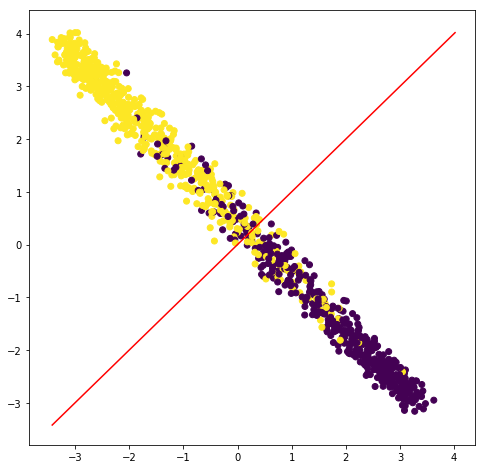

In [10]:
#plot correct choice vs the decision line

mini_batch_size=test_target.size()[0];
output = model(test_input.narrow(0, 0, mini_batch_size))
fig=plt.figure(figsize=(8, 8))
color=test_target.cpu()
plt.plot([torch.min(output[0]),torch.max(output[0])],[torch.min(output[0]),torch.max(output[0])],c='r')
plt.scatter(output[0].cpu().detach().numpy()[:,0],output[0].cpu().detach().numpy()[:,1],c=color)
plt.show()


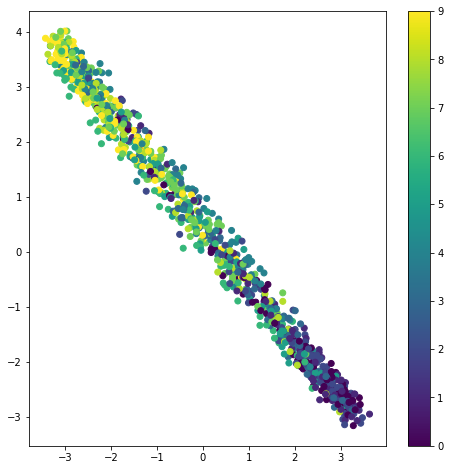

In [11]:
#plot the spacialization colored by the number

mini_batch_size=test_target.size()[0];
output = model(test_input.narrow(0, 0, mini_batch_size))
fig=plt.figure(figsize=(8, 8))
color=test_classes[:,1].cpu()
plt.scatter(output[0].cpu().detach().numpy()[:,0],output[0].cpu().detach().numpy()[:,1],c=color)
plt.colorbar()
plt.show()

# utilitary

In [12]:
model=ConvNet3_al()
sum(p.numel() for p in model.parameters() )

70544